In [10]:
import csv
import os
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from scipy.sparse import hstack

from entitypedia.classifier.preprocess import extract_abstract, tokenize, remove_tags, extract_categories
from entitypedia.corpora.datasets import DocumentClassifierDataset


def load_dataset(wiki_dir, seed_ids, categories, seed_dir):
    X, y = [], []
    cats = []
    dataset = DocumentClassifierDataset(wiki_dir, seed_dir=seed_dir)
    for j in dataset.create_prediction_set():
        id = j['id']
        if id not in seed_ids:
            continue
        try:
            text = extract_abstract(j['text'])
        except IndexError:
            continue
        text = remove_tags(text)
        X.append(text)
        cats.append(' '.join(categories[id]))
        y.append(seed_ids[id])
        
    return X, cats, y


def load_prediction_dataset(wiki_dir, seed_ids, categories, seed_dir):
    X, titles = [], []
    cats = []
    dataset = DocumentClassifierDataset(wiki_dir, seed_dir=seed_dir)
    for j in dataset.create_prediction_set():
        id = j['id']
        if id in seed_ids:
            continue
        try:
            text = extract_abstract(j['text'])
        except IndexError:
            continue
        text = remove_tags(text)
        X.append(text)
        cats.append(' '.join(categories[id]))
        titles.append(j['title'])
        
    return X, cats, titles


def load_categories(file_path):
    with open(file_path) as f:
        lines = [line.strip().split('\t') for line in f]
    ids, cats = [], []
    for row in lines:
        ids.append(row[0])
        cats.append(row[1])
    cats = extract_categories(cats)
    res = defaultdict(list)
    for id, cat in zip(ids, cats):
        res[id].append(cat)

    return res


def load_seed(file_path):
    seeds = {}
    with open(file_path) as f:
        reader = csv.reader(f)
        for row in reader:
            label, title, id = row
            seeds[id] = label
    return seeds


BASE_DIR = 'data/'
seed_file = os.path.join(BASE_DIR, 'interim/seeds.csv')
wiki_dir = os.path.join(BASE_DIR, 'extracted')
category_file = os.path.join(BASE_DIR, 'raw/categories.tsv')
seed_dir = os.path.join(BASE_DIR, 'raw/seeds')


print('Loading dataset...')
categories = load_categories(category_file)
seeds = load_seed(seed_file)
X, cats, y = load_dataset(wiki_dir, seeds, categories, seed_dir)
X_predict, cats_predict, titles = load_prediction_dataset(wiki_dir, seeds, categories, seed_dir)
print('Loaded!')

Loading dataset...


Loaded!


## ベースラインモデルの作成
まずはベースラインモデルを作成する。ここでは、各文書をBoWで表し、TF-IDF値に変換する。これをモデルへの入力とする。

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print('Vectorizing...')
vectorizer = TfidfVectorizer(tokenizer=tokenize, max_features=10000)
x_vec = vectorizer.fit_transform(X)
category_vectorizer = CountVectorizer()
cat_vec = category_vectorizer.fit_transform(cats)
x_vec = hstack([x_vec, cat_vec])

x_train, x_test, y_train, y_test = train_test_split(x_vec, y, test_size=0.1, random_state=42)

print('Fitting...')
clf = LinearSVC()
clf.fit(x_train, y_train)

print('Predicting...')
y_pred = clf.predict(x_test)
y_pred_train = clf.predict(x_train)

print('Evaluating...')
print(f1_score(y_test, y_pred, average='micro'))
print(f1_score(y_test, y_pred, average='macro'))
print(f1_score(y_train, y_pred_train, average='micro'))
print(f1_score(y_train, y_pred_train, average='macro'))
print(classification_report(y_test, y_pred, digits=3))

Vectorizing...


Fitting...


Predicting...
Evaluating...
0.9443535188216039
0.932514614160318
0.9995449995449995


0.9994520179000747
                                                                  precision    recall  f1-score   support

                                               color/color_other      1.000     1.000     1.000         6
                                                         concept      0.500     0.333     0.400         9
                                          disease/animal_disease      0.857     0.857     0.857         7
                                               event/event_other      0.875     1.000     0.933         7
                                   event/incident/incident_other      1.000     1.000     1.000        12
                                              event/incident/war      1.000     1.000     1.000         8
                             event/natural_phenomenon/earthquake      1.000     1.000     1.000         8
                       event/natural_phenomenon/natural_disaster      1.000     1.000     1.000        13
               event/natur

分類のモデルにはロジスティック回帰を用いる。ここで、正則化にはL1正則化を用いる。ストップワードの除去を期待できるからである。

In [49]:
from sklearn.calibration import CalibratedClassifierCV

base_estimator = LinearSVC()
clf = CalibratedClassifierCV(base_estimator)
clf.fit(x_train, y_train)


CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=3, method='sigmoid')

学習が完了したら、テストデータに対して予測を行う。

In [50]:
y_pred = clf.predict(x_test)
f1_score(y_test, y_pred, average='micro')
#y_pred = clf.predict_proba(x_test)
#len([y for y in y_pred if max(y) < 0.7])

0.9418985270049101

最後に、予測したデータと正解データを用いて評価を行う。評価にはF1を用いる。

In [5]:
print(f1_score(y_test, y_pred, average='micro'))
print(f1_score(y_test, y_pred, average='macro'))

0.9518981516987499


0.8954278457630136


/Users/smap4/VirtualEnv/entitypediaVenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


classification_reportを用いて、各カテゴリごとの評価を表示する。

In [6]:
print(classification_report(y_test, y_pred, digits=3))

                                                                  precision    recall  f1-score   support

                                               color/color_other      0.893     0.926     0.909        54
                                              color/nature_color      0.000     0.000     0.000         2
                                                         concept      0.804     0.752     0.778       525
                                          disease/animal_disease      0.909     0.918     0.914        98
                                           disease/disease_other      1.000     0.727     0.842        11
                                               event/event_other      0.987     0.982     0.984       226
                                   event/incident/incident_other      0.952     0.994     0.973       179
                                              event/incident/war      0.977     0.995     0.986       633
                             event/natural_ph

/Users/smap4/VirtualEnv/entitypediaVenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


学習曲線を描くための関数を定義する

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    return plt

実際に学習曲線を描いてみる。

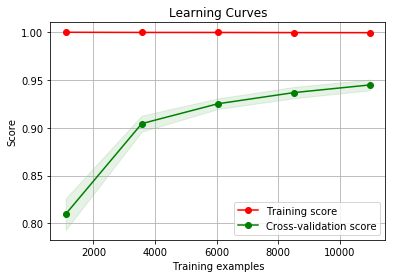

In [42]:
title = "Learning Curves"
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
estimator = LinearSVC()
plot_learning_curve(estimator, title, x_vec, y, cv=cv)

plt.show()

学習スコアと検証スコアに若干(1%くらい?)の差がある。

In [ ]:
base_estimator = LinearSVC()
clf = CalibratedClassifierCV(base_estimator)
clf.fit(x_vec, y)

In [ ]:
x_pred = vectorizer.transform(X_predict)
cats_pred = category_vectorizer.transform(cats_predict)
x_pred = hstack([x_pred, cats_pred])
y_pred = clf.predict(x_pred)
# y_prob = clf.predict_proba(x_pred)